This notebook shows how the stochastic model is still not providing nearly enough variance. In the extra-tropics it maybe provides enough variance, but in the tropcs where the extreme moistening and drying occurs, it does not output nearly extreme enough values. 

In [1]:
from uwnet.stochastic_parameterization.residual_stochastic_state_model import (
    StochasticStateModel,
)
from uwnet.thermo import integrate_q2
from uwnet.stochastic_parameterization.utils import get_dataset
from matplotlib import pyplot as plt
import xarray as xr

dir_ = '/Users/stewart/projects/uwnet/uwnet/stochastic_parameterization/'
base_model_location = dir_ + 'full_model/1.pkl'
ds_location = dir_ + 'training.nc'

base_model = StochasticStateModel(
    return_stochastic_state=False,
    binning_quantiles=(1,),
    base_model_location=base_model_location,
    ds_location=ds_location,
    verbose=False)
base_model.train()

stochastic_model = StochasticStateModel(
    return_stochastic_state=False,
    base_model_location=base_model_location,
    ds_location=ds_location,
    binning_method='column_integrated_qt_residuals',
    verbose=False)
stochastic_model.train()

ds = get_dataset(ds_location=ds_location, set_eta=False)

input_ = ds.isel(time=[100])


In [2]:
def plot_predicted_q2(base_model, stochastic_model):
    true_qt_forcing = (
        ds.isel(time=101).QT -
        ds.isel(time=100).QT -
        (10800 * ds.isel(time=100).FQT)
    ) / .125
    titles = []
    precips = []
    precips.append(-integrate_q2(true_qt_forcing, ds.layer_mass).expand_dims('time'))
    titles.append('True Data')
    precips.append(-integrate_q2(base_model.predict(input_).QT, ds.layer_mass))
    titles.append('Base Model')
    precips.append(-integrate_q2(stochastic_model.predict(input_).QT, ds.layer_mass))
    titles.append('Stochastic Model')

    for idx in range(1, 4):
        stochastic_model.simulate_eta(t_start=0, n_time_steps=100)
        precips.append(-integrate_q2(stochastic_model.predict(input_).QT, ds.layer_mass))
        titles.append(f'Random Simulation #{idx}')
    precips = xr.concat(precips, dim=titles).rename({'concat_dim': 'model'})
    precips.isel(time=0).plot(col='model', col_wrap=3, aspect=2)
    plt.show()

We see that while the stochastic model does slightly better than the non-stochastic model, it still does not provide nearly enough variance:

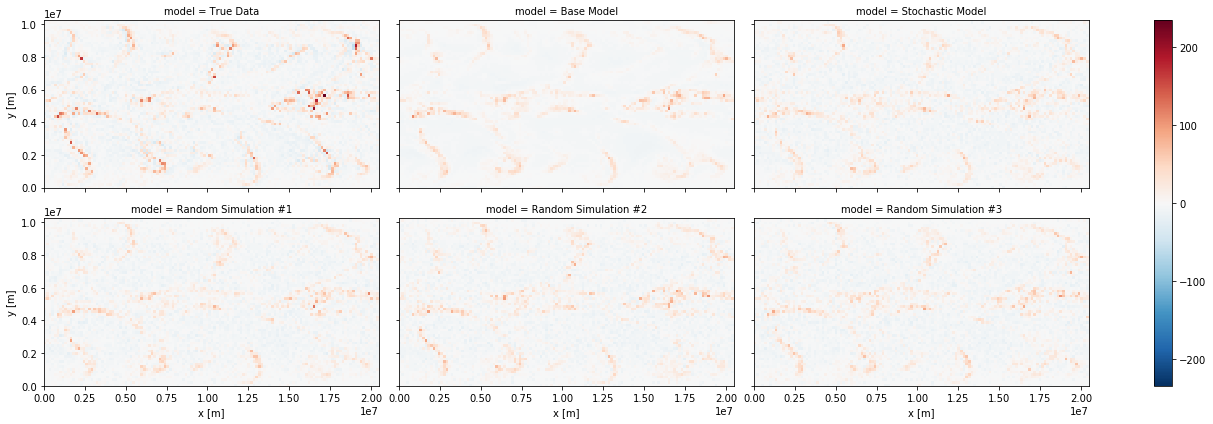

In [3]:
%matplotlib inline
plot_predicted_q2(base_model, stochastic_model)

Binning on Precip causes the model to do even worse.

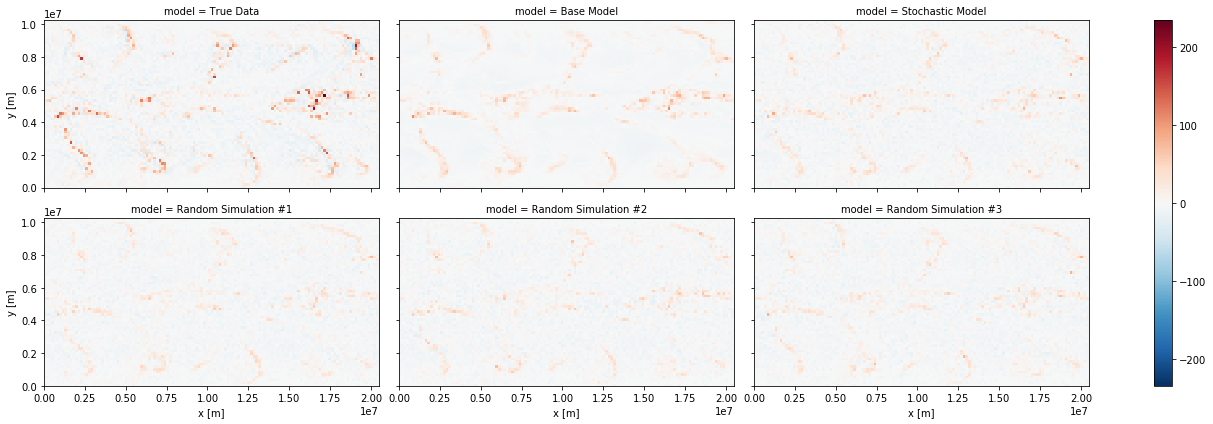

In [4]:
%matplotlib inline
precip_stochastic_model = StochasticStateModel(
    return_stochastic_state=False,
    base_model_location=base_model_location,
    ds_location=ds_location,
    binning_method='precip',
    verbose=False)
precip_stochastic_model.train()
plot_predicted_q2(base_model, stochastic_model)